In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from align import AlignDlib
from keras.models import model_from_json
from keras.models import load_model
from PIL import Image

Using TensorFlow backend.


In [2]:
#face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
ATTRS_NAME = "./data/lfw_attributes.txt"
IMAGES_NAME = "./data/lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "./data/lfw.tgz"

In [3]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
def fourier_transformation(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    rows, cols = img.shape
    crow, ccol = rows/2, cols/2
    fshift[int(crow-5):int(crow+5), int(ccol-5):int(ccol+5)] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

In [5]:
def load_dataset(path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    img_data_list=[]       
    input_img=cv2.imread(path)
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
    x,y,w,h = faces[0]
    face = input_img[y:y+h,x:x+w]
    print(face.shape)
    #face = fourier_transformation(face)
    face=cv2.resize(face,(32,32))
    img_data_list.append(face)
    img_data = np.stack(img_data_list).astype('uint8')
    print("New photo loaded")
    return img_data/ 255.0 - 0.5

In [6]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    #df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    #df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    #df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                #print(img.shape)
                #img = fourier_transformation(img)
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                foldername = os.path.split(m.name)
                filename = os.path.split(m.name)[-1]
                fname_splitted = filename[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img, "File": filename, "Path": foldername })

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')
    all_photos = all_photos.astype('float32') / 255.0 - 0.5

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids#all_attrs

In [7]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<TarInfo 'lfw' at 0x7f9873381ae0>
<TarInfo 'lfw/George_HW_Bush' at 0x7f9873381bb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7f9873381a10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7f9873381c80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7f9873381d50>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7f9873381ef0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7f9873381e20>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7f9854801120>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7f98548011f0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7f98548012c0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7f9854801390>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7f9854801460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7f9854801530>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7f9854801600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0047.jpg' at 0x7f98547b3bb0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0048.jpg' at 0x7f98547b3c80>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0049.jpg' at 0x7f98547b3d50>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0050.jpg' at 0x7f98547b3e20>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0051.jpg' at 0x7f98547b3ef0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0052.jpg' at 0x7f98547b3050>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0053.jpg' at 0x7f98547b7120>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0054.jpg' at 0x7f98547b71f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0055.jpg' at 0x7f98547b72c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0056.jpg' at 0x7f98547b7390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0057.jpg' at 0x7f98547b7460>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0058.jpg' at 0x7f98547b7530>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/Bob_Beauprez' at 0x7f98547e5390>
<TarInfo 'lfw/Bob_Beauprez/Bob_Beauprez_0001.jpg' at 0x7f98547e5460>
<TarInfo 'lfw/Bob_Beauprez/Bob_Beauprez_0002.jpg' at 0x7f98547e5050>
<TarInfo 'lfw/George_W_Bush' at 0x7f98547e5600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0001.jpg' at 0x7f98547e56d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0002.jpg' at 0x7f98547e5530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0003.jpg' at 0x7f98547e5870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0004.jpg' at 0x7f98547e5940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0005.jpg' at 0x7f98547e5a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0006.jpg' at 0x7f98547e5ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0007.jpg' at 0x7f98547e5bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0008.jpg' at 0x7f98547e5c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0009.jpg' at 0x7f98547e5d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0010.jpg' at 0x7f98547e5e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0011.jpg' at 0x

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0209.jpg' at 0x7f9854796600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0210.jpg' at 0x7f98547966d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0211.jpg' at 0x7f98547967a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0212.jpg' at 0x7f9854796870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0213.jpg' at 0x7f9854796940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0214.jpg' at 0x7f9854796a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0215.jpg' at 0x7f9854796ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0216.jpg' at 0x7f9854796bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0217.jpg' at 0x7f9854796c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0218.jpg' at 0x7f9854796d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0219.jpg' at 0x7f9854796e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0220.jpg' at 0x7f9854796ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0221.jpg' at 0x7f9854796050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0222.jpg' at 0x7f985479a120>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0415.jpg' at 0x7f9854744390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0416.jpg' at 0x7f9854744460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0417.jpg' at 0x7f9854744530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0418.jpg' at 0x7f9854744600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0419.jpg' at 0x7f98547446d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0420.jpg' at 0x7f98547447a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0421.jpg' at 0x7f9854744870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0422.jpg' at 0x7f9854744940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0423.jpg' at 0x7f9854744a10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0424.jpg' at 0x7f9854744ae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0425.jpg' at 0x7f9854744bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0426.jpg' at 0x7f9854744c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0427.jpg' at 0x7f9854744d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0428.jpg' at 0x7f9854744e20>
<TarIn

<TarInfo 'lfw/Horst_Koehler/Horst_Koehler_0003.jpg' at 0x7f98546f9870>
<TarInfo 'lfw/Terry_Bradshaw' at 0x7f98546f9940>
<TarInfo 'lfw/Terry_Bradshaw/Terry_Bradshaw_0001.jpg' at 0x7f98546f9a10>
<TarInfo 'lfw/Michael_Chang' at 0x7f98546f97a0>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0001.jpg' at 0x7f98546f9bb0>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0002.jpg' at 0x7f98546f9ae0>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0003.jpg' at 0x7f98546f9d50>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0004.jpg' at 0x7f98546f9e20>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0005.jpg' at 0x7f98546f9ef0>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0006.jpg' at 0x7f98546f9c80>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0007.jpg' at 0x7f98546fc120>
<TarInfo 'lfw/Michael_Chang/Michael_Chang_0008.jpg' at 0x7f98546fc1f0>
<TarInfo 'lfw/Thomas_Birmingham' at 0x7f98546fc2c0>
<TarInfo 'lfw/Thomas_Birmingham/Thomas_Birmingham_0001.jpg' at 0x7f98546fc390>
<TarInfo 'lfw/Thomas_Birmingham/Thomas_Birmingham_0002.jpg' 

<TarInfo 'lfw/Jose_Serra/Jose_Serra_0005.jpg' at 0x7f9854727e20>
<TarInfo 'lfw/Jose_Serra/Jose_Serra_0006.jpg' at 0x7f9854727ef0>
<TarInfo 'lfw/Jose_Serra/Jose_Serra_0007.jpg' at 0x7f9854727bb0>
<TarInfo 'lfw/Jose_Serra/Jose_Serra_0008.jpg' at 0x7f985472b120>
<TarInfo 'lfw/Jose_Serra/Jose_Serra_0009.jpg' at 0x7f985472b1f0>
<TarInfo 'lfw/Cabas' at 0x7f985472b2c0>
<TarInfo 'lfw/Cabas/Cabas_0001.jpg' at 0x7f985472b390>
<TarInfo 'lfw/Charlie_Zaa' at 0x7f985472b050>
<TarInfo 'lfw/Charlie_Zaa/Charlie_Zaa_0001.jpg' at 0x7f985472b530>
<TarInfo 'lfw/Charlie_Zaa/Charlie_Zaa_0002.jpg' at 0x7f985472b460>
<TarInfo 'lfw/Brandon_Robinson' at 0x7f985472b6d0>
<TarInfo 'lfw/Brandon_Robinson/Brandon_Robinson_0001.jpg' at 0x7f985472b7a0>
<TarInfo 'lfw/Mark_Komara' at 0x7f985472b600>
<TarInfo 'lfw/Mark_Komara/Mark_Komara_0001.jpg' at 0x7f985472b940>
<TarInfo 'lfw/Casy_Preslar' at 0x7f985472b870>
<TarInfo 'lfw/Casy_Preslar/Casy_Preslar_0001.jpg' at 0x7f985472bae0>
<TarInfo 'lfw/Justin_Timberlake' at 0x7f985

<TarInfo 'lfw/Alan_Greenspan/Alan_Greenspan_0005.jpg' at 0x7f98546e02c0>
<TarInfo 'lfw/Benjamin_Netanyahu' at 0x7f98546e0390>
<TarInfo 'lfw/Benjamin_Netanyahu/Benjamin_Netanyahu_0001.jpg' at 0x7f98546e0460>
<TarInfo 'lfw/Benjamin_Netanyahu/Benjamin_Netanyahu_0002.jpg' at 0x7f98546e0050>
<TarInfo 'lfw/Benjamin_Netanyahu/Benjamin_Netanyahu_0003.jpg' at 0x7f98546e0600>
<TarInfo 'lfw/Benjamin_Netanyahu/Benjamin_Netanyahu_0004.jpg' at 0x7f98546e06d0>
<TarInfo 'lfw/Benjamin_Netanyahu/Benjamin_Netanyahu_0005.jpg' at 0x7f98546e07a0>
<TarInfo 'lfw/Nick_Nolte' at 0x7f98546e0870>
<TarInfo 'lfw/Nick_Nolte/Nick_Nolte_0001.jpg' at 0x7f98546e0940>
<TarInfo 'lfw/Nick_Nolte/Nick_Nolte_0002.jpg' at 0x7f98546e0530>
<TarInfo 'lfw/Nick_Nolte/Nick_Nolte_0003.jpg' at 0x7f98546e0ae0>
<TarInfo 'lfw/Nick_Nolte/Nick_Nolte_0004.jpg' at 0x7f98546e0bb0>
<TarInfo 'lfw/Nick_Nolte/Nick_Nolte_0005.jpg' at 0x7f98546e0c80>
<TarInfo 'lfw/Stephanie_Zimbalist' at 0x7f98546e0d50>
<TarInfo 'lfw/Stephanie_Zimbalist/Stephanie_Z

<TarInfo 'lfw/James_Gandolfini' at 0x7f9854693390>
<TarInfo 'lfw/James_Gandolfini/James_Gandolfini_0001.jpg' at 0x7f9854693460>
<TarInfo 'lfw/James_Gandolfini/James_Gandolfini_0002.jpg' at 0x7f9854693120>
<TarInfo 'lfw/James_Gandolfini/James_Gandolfini_0003.jpg' at 0x7f9854693600>
<TarInfo 'lfw/Hamid_Karzai' at 0x7f98546936d0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0001.jpg' at 0x7f98546937a0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0002.jpg' at 0x7f9854693530>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0003.jpg' at 0x7f9854693940>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0004.jpg' at 0x7f9854693a10>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0005.jpg' at 0x7f9854693ae0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0006.jpg' at 0x7f9854693bb0>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0007.jpg' at 0x7f9854693c80>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0008.jpg' at 0x7f9854693d50>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0009.jpg' at 0x7f9854693e20>
<TarInfo 'lfw/Hamid_Karzai/Hamid_Karzai_0010.jpg' 

<TarInfo 'lfw/Amer_al-Saadi' at 0x7f9854643870>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0001.jpg' at 0x7f9854643940>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0002.jpg' at 0x7f98546436d0>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0003.jpg' at 0x7f9854643ae0>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0004.jpg' at 0x7f9854643bb0>
<TarInfo 'lfw/Carlo_Ancelotti' at 0x7f9854643c80>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0001.jpg' at 0x7f9854643d50>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0002.jpg' at 0x7f9854643a10>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0003.jpg' at 0x7f9854643ef0>
<TarInfo 'lfw/Barbra_Streisand' at 0x7f9854643e20>
<TarInfo 'lfw/Barbra_Streisand/Barbra_Streisand_0001.jpg' at 0x7f9854645050>
<TarInfo 'lfw/Barbra_Streisand/Barbra_Streisand_0002.jpg' at 0x7f9854645120>
<TarInfo 'lfw/Barbra_Streisand/Barbra_Streisand_0003.jpg' at 0x7f98546452c0>
<TarInfo 'lfw/Ira_Einhorn' at 0x7f9854645390>
<TarInfo 'lfw/Ira_Einhorn/Ira_Einhorn_0001.jpg' at 0x7f9854645460

<TarInfo 'lfw/Ariel_Sharon/Ariel_Sharon_0075.jpg' at 0x7f98545f62c0>
<TarInfo 'lfw/Ariel_Sharon/Ariel_Sharon_0076.jpg' at 0x7f98545f6390>
<TarInfo 'lfw/Ariel_Sharon/Ariel_Sharon_0077.jpg' at 0x7f98545f6460>
<TarInfo 'lfw/Kevin_Garnett' at 0x7f98545f6530>
<TarInfo 'lfw/Kevin_Garnett/Kevin_Garnett_0001.jpg' at 0x7f98545f6600>
<TarInfo 'lfw/Joe_Torre' at 0x7f98545f6120>
<TarInfo 'lfw/Joe_Torre/Joe_Torre_0001.jpg' at 0x7f98545f67a0>
<TarInfo 'lfw/Joe_Torre/Joe_Torre_0002.jpg' at 0x7f98545f66d0>
<TarInfo 'lfw/Joe_Torre/Joe_Torre_0003.jpg' at 0x7f98545f6940>
<TarInfo 'lfw/Joe_Torre/Joe_Torre_0004.jpg' at 0x7f98545f6a10>
<TarInfo 'lfw/Jim_Spinoza' at 0x7f98545f6ae0>
<TarInfo 'lfw/Jim_Spinoza/Jim_Spinoza_0001.jpg' at 0x7f98545f6bb0>
<TarInfo 'lfw/Mohammad_Khatami' at 0x7f98545f6870>
<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0001.jpg' at 0x7f98545f6d50>
<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0002.jpg' at 0x7f98545f6c80>
<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0003.jpg' at

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0192.jpg' at 0x7f98546277a0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0193.jpg' at 0x7f9854627870>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0194.jpg' at 0x7f9854627940>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0195.jpg' at 0x7f9854627a10>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0196.jpg' at 0x7f9854627ae0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0197.jpg' at 0x7f9854627bb0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0198.jpg' at 0x7f9854627c80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0199.jpg' at 0x7f9854627d50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0200.jpg' at 0x7f9854627e20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0201.jpg' at 0x7f9854627ef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0202.jpg' at 0x7f9854627120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0203.jpg' at 0x7f9854629120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0204.jpg' at 0x7f98546291f0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0205.jpg' at 0x7f98546292c0>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Amelie_Mauresmo' at 0x7f98545dad50>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0001.jpg' at 0x7f98545dd120>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0002.jpg' at 0x7f98545dd050>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0003.jpg' at 0x7f98545dd2c0>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0004.jpg' at 0x7f98545dd390>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0005.jpg' at 0x7f98545dd460>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0006.jpg' at 0x7f98545dd530>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0007.jpg' at 0x7f98545dd600>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0008.jpg' at 0x7f98545dd6d0>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0009.jpg' at 0x7f98545dd7a0>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0010.jpg' at 0x7f98545dd870>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0011.jpg' at 0x7f98545dd940>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0012.jpg' at 0x7f98545dda10>
<TarInfo 'lfw/Amelie_Mauresmo/Amelie_Mauresmo_0013

<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0003.jpg' at 0x7f985458bae0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0004.jpg' at 0x7f985458bbb0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0005.jpg' at 0x7f985458bc80>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0006.jpg' at 0x7f985458bd50>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0007.jpg' at 0x7f985458be20>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0008.jpg' at 0x7f985458bef0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0009.jpg' at 0x7f985458ba10>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0010.jpg' at 0x7f9854590120>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0011.jpg' at 0x7f98545901f0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0012.jpg' at 0x7f98545902c0>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0013.jpg' at 0x7f9854590390>
<TarInfo 'lfw/Taha_Yassin_Ramadan/Taha_Yassin_Ramadan_0014.jpg' at 0x7f9854590460>
<Tar

<TarInfo 'lfw/John_Ashcroft/John_Ashcroft_0053.jpg' at 0x7f98545447a0>
<TarInfo 'lfw/Elizabeth_Berkeley' at 0x7f9854544870>
<TarInfo 'lfw/Elizabeth_Berkeley/Elizabeth_Berkeley_0001.jpg' at 0x7f9854544940>
<TarInfo 'lfw/Jean-Pierre_Raffarin' at 0x7f9854544050>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0001.jpg' at 0x7f9854544ae0>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0002.jpg' at 0x7f9854544a10>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0003.jpg' at 0x7f9854544c80>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0004.jpg' at 0x7f9854544d50>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0005.jpg' at 0x7f9854544e20>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0006.jpg' at 0x7f9854544ef0>
<TarInfo 'lfw/Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0007.jpg' at 0x7f9854544bb0>
<TarInfo 'lfw/Horace_Newcomb' at 0x7f985454a050>
<TarInfo 'lfw/Horace_Newcomb/Horace_Newcomb_0001.jpg' at 0x7f985454a1f0>
<TarInfo 'lfw/Priscilla

<TarInfo 'lfw/Harald_Ringstorff' at 0x7f98545002c0>
<TarInfo 'lfw/Harald_Ringstorff/Harald_Ringstorff_0001.jpg' at 0x7f9854500530>
<TarInfo 'lfw/Sebastian_Porto' at 0x7f9854500460>
<TarInfo 'lfw/Sebastian_Porto/Sebastian_Porto_0001.jpg' at 0x7f98545006d0>
<TarInfo 'lfw/Robert_Redford' at 0x7f9854500600>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0001.jpg' at 0x7f9854500870>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0002.jpg' at 0x7f98545007a0>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0003.jpg' at 0x7f9854500a10>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0004.jpg' at 0x7f9854500ae0>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0005.jpg' at 0x7f9854500bb0>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0006.jpg' at 0x7f9854500c80>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0007.jpg' at 0x7f9854500d50>
<TarInfo 'lfw/Robert_Redford/Robert_Redford_0008.jpg' at 0x7f9854500e20>
<TarInfo 'lfw/Miles_Stewart' at 0x7f9854500ef0>
<TarInfo 'lfw/Miles_Stewart/Miles_Stewart_0001.jpg' at 0x7f9854

<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0009.jpg' at 0x7f98544b8530>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0010.jpg' at 0x7f98544b8600>
<TarInfo 'lfw/Richard_Gephardt/Richard_Gephardt_0011.jpg' at 0x7f98544b86d0>
<TarInfo 'lfw/Dick_Armey' at 0x7f98544b87a0>
<TarInfo 'lfw/Dick_Armey/Dick_Armey_0001.jpg' at 0x7f98544b8870>
<TarInfo 'lfw/Kelly_Ripa' at 0x7f98544b8120>
<TarInfo 'lfw/Kelly_Ripa/Kelly_Ripa_0001.jpg' at 0x7f98544b8a10>
<TarInfo 'lfw/Matt_Dillon' at 0x7f98544b8940>
<TarInfo 'lfw/Matt_Dillon/Matt_Dillon_0001.jpg' at 0x7f98544b8bb0>
<TarInfo 'lfw/Matt_Dillon/Matt_Dillon_0002.jpg' at 0x7f98544b8ae0>
<TarInfo 'lfw/Matt_Dillon/Matt_Dillon_0003.jpg' at 0x7f98544b8d50>
<TarInfo 'lfw/Elsa_Zylberstein' at 0x7f98544b8e20>
<TarInfo 'lfw/Elsa_Zylberstein/Elsa_Zylberstein_0001.jpg' at 0x7f98544b8ef0>
<TarInfo 'lfw/Elsa_Zylberstein/Elsa_Zylberstein_0002.jpg' at 0x7f98544b8c80>
<TarInfo 'lfw/Elsa_Zylberstein/Elsa_Zylberstein_0003.jpg' at 0x7f98544bd120>
<TarInfo 'lfw/Elsa_Z

<TarInfo 'lfw/Yao_Ming/Yao_Ming_0006.jpg' at 0x7f98544ebef0>
<TarInfo 'lfw/Yao_Ming/Yao_Ming_0007.jpg' at 0x7f98544ebbb0>
<TarInfo 'lfw/Yao_Ming/Yao_Ming_0008.jpg' at 0x7f9854470120>
<TarInfo 'lfw/George_Papandreou' at 0x7f98544701f0>
<TarInfo 'lfw/George_Papandreou/George_Papandreou_0001.jpg' at 0x7f98544702c0>
<TarInfo 'lfw/George_Papandreou/George_Papandreou_0002.jpg' at 0x7f9854470050>
<TarInfo 'lfw/George_Papandreou/George_Papandreou_0003.jpg' at 0x7f9854470460>
<TarInfo 'lfw/George_Papandreou/George_Papandreou_0004.jpg' at 0x7f9854470530>
<TarInfo 'lfw/Mesut_Yilmaz' at 0x7f9854470600>
<TarInfo 'lfw/Mesut_Yilmaz/Mesut_Yilmaz_0001.jpg' at 0x7f98544706d0>
<TarInfo 'lfw/Mesut_Yilmaz/Mesut_Yilmaz_0002.jpg' at 0x7f9854470390>
<TarInfo 'lfw/Marat_Safin' at 0x7f9854470870>
<TarInfo 'lfw/Marat_Safin/Marat_Safin_0001.jpg' at 0x7f9854470940>
<TarInfo 'lfw/Marat_Safin/Marat_Safin_0002.jpg' at 0x7f98544707a0>
<TarInfo 'lfw/Marat_Safin/Marat_Safin_0003.jpg' at 0x7f9854470ae0>
<TarInfo 'lfw/Gab

<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0009.jpg' at 0x7f98544a3ae0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0010.jpg' at 0x7f98544a3bb0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0011.jpg' at 0x7f98544a3c80>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0012.jpg' at 0x7f98544a3d50>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0013.jpg' at 0x7f98544a3e20>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0014.jpg' at 0x7f98544a3ef0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0015.jpg' at 0x7f98544a3530>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0016.jpg' at 0x7f98544a9050>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0017.jpg' at 0x7f98544a91f0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0018.jpg' at 0x7f98544a92c0>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0019.jpg' at 0x7f98544a9390>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_0020.jpg' at 0x7f98544a9460>
<TarInfo 'lfw/Lindsay_Davenport/Lindsay_Davenport_00

<TarInfo 'lfw/Doris_Schroeder/Doris_Schroeder_0004.jpg' at 0x7f9854457e20>
<TarInfo 'lfw/Gabi_Zimmer' at 0x7f985445b120>
<TarInfo 'lfw/Gabi_Zimmer/Gabi_Zimmer_0001.jpg' at 0x7f985445b1f0>
<TarInfo 'lfw/Vinnie_Jones' at 0x7f985445b050>
<TarInfo 'lfw/Vinnie_Jones/Vinnie_Jones_0001.jpg' at 0x7f985445b390>
<TarInfo 'lfw/Tina_Fey' at 0x7f985445b2c0>
<TarInfo 'lfw/Tina_Fey/Tina_Fey_0001.jpg' at 0x7f985445b530>
<TarInfo 'lfw/Dick_Vermeil' at 0x7f985445b460>
<TarInfo 'lfw/Dick_Vermeil/Dick_Vermeil_0001.jpg' at 0x7f985445b6d0>
<TarInfo 'lfw/Dick_Vermeil/Dick_Vermeil_0002.jpg' at 0x7f985445b600>
<TarInfo 'lfw/Larry_Wilmore' at 0x7f985445b870>
<TarInfo 'lfw/Larry_Wilmore/Larry_Wilmore_0001.jpg' at 0x7f985445b940>
<TarInfo 'lfw/Gilles_Panizzi' at 0x7f985445b7a0>
<TarInfo 'lfw/Gilles_Panizzi/Gilles_Panizzi_0001.jpg' at 0x7f985445bae0>
<TarInfo 'lfw/Ahmed_Ghazi' at 0x7f985445ba10>
<TarInfo 'lfw/Ahmed_Ghazi/Ahmed_Ghazi_0001.jpg' at 0x7f985445bc80>
<TarInfo 'lfw/Hussein_Malik' at 0x7f985445bbb0>
<TarI

<TarInfo 'lfw/Richard_Butler/Richard_Butler_0002.jpg' at 0x7f985441b2c0>
<TarInfo 'lfw/Sabah_Al-Ahmad_Al-Jaber_Al-Sabah' at 0x7f985441b6d0>
<TarInfo 'lfw/Sabah_Al-Ahmad_Al-Jaber_Al-Sabah/Sabah_Al-Ahmad_Al-Jaber_Al-Sabah_0001.jpg' at 0x7f985441b7a0>
<TarInfo 'lfw/Liza_Minnelli' at 0x7f985441b600>
<TarInfo 'lfw/Liza_Minnelli/Liza_Minnelli_0001.jpg' at 0x7f985441b940>
<TarInfo 'lfw/Liza_Minnelli/Liza_Minnelli_0002.jpg' at 0x7f985441b870>
<TarInfo 'lfw/Liza_Minnelli/Liza_Minnelli_0003.jpg' at 0x7f985441bae0>
<TarInfo 'lfw/Liza_Minnelli/Liza_Minnelli_0004.jpg' at 0x7f985441bbb0>
<TarInfo 'lfw/Liza_Minnelli/Liza_Minnelli_0005.jpg' at 0x7f985441bc80>
<TarInfo 'lfw/Liza_Minnelli/Liza_Minnelli_0006.jpg' at 0x7f985441bd50>
<TarInfo 'lfw/Liza_Minnelli/Liza_Minnelli_0007.jpg' at 0x7f985441be20>
<TarInfo 'lfw/Miguel_Cotto' at 0x7f985441bef0>
<TarInfo 'lfw/Miguel_Cotto/Miguel_Cotto_0001.jpg' at 0x7f985441ba10>
<TarInfo 'lfw/Ana_Palacio' at 0x7f985441e050>
<TarInfo 'lfw/Ana_Palacio/Ana_Palacio_0001.j

<TarInfo 'lfw/Joschka_Fischer/Joschka_Fischer_0013.jpg' at 0x7f98543d2d50>
<TarInfo 'lfw/Joschka_Fischer/Joschka_Fischer_0014.jpg' at 0x7f98543d2e20>
<TarInfo 'lfw/Joschka_Fischer/Joschka_Fischer_0015.jpg' at 0x7f98543d2ef0>
<TarInfo 'lfw/Joschka_Fischer/Joschka_Fischer_0016.jpg' at 0x7f98543d2460>
<TarInfo 'lfw/Joschka_Fischer/Joschka_Fischer_0017.jpg' at 0x7f98543d7050>
<TarInfo 'lfw/Joschka_Fischer/Joschka_Fischer_0018.jpg' at 0x7f98543d71f0>
<TarInfo 'lfw/Joschka_Fischer/Joschka_Fischer_0019.jpg' at 0x7f98543d72c0>
<TarInfo 'lfw/David_McCullough' at 0x7f98543d7390>
<TarInfo 'lfw/David_McCullough/David_McCullough_0001.jpg' at 0x7f98543d7460>
<TarInfo 'lfw/Sadam_Hassan' at 0x7f98543d7120>
<TarInfo 'lfw/Sadam_Hassan/Sadam_Hassan_0001.jpg' at 0x7f98543d7600>
<TarInfo 'lfw/Naji_Sabri' at 0x7f98543d7530>
<TarInfo 'lfw/Naji_Sabri/Naji_Sabri_0001.jpg' at 0x7f98543d77a0>
<TarInfo 'lfw/Naji_Sabri/Naji_Sabri_0002.jpg' at 0x7f98543d76d0>
<TarInfo 'lfw/Naji_Sabri/Naji_Sabri_0003.jpg' at 0x7f985

<TarInfo 'lfw/Juan_Sanchez' at 0x7f9854391ef0>
<TarInfo 'lfw/Juan_Sanchez/Juan_Sanchez_0001.jpg' at 0x7f9854391e20>
<TarInfo 'lfw/Demetrius_Ferraciu' at 0x7f9854397050>
<TarInfo 'lfw/Demetrius_Ferraciu/Demetrius_Ferraciu_0001.jpg' at 0x7f98543971f0>
<TarInfo 'lfw/Demetrius_Ferraciu/Demetrius_Ferraciu_0002.jpg' at 0x7f9854397120>
<TarInfo 'lfw/Peter_Mansbridge' at 0x7f9854397390>
<TarInfo 'lfw/Peter_Mansbridge/Peter_Mansbridge_0001.jpg' at 0x7f9854397460>
<TarInfo 'lfw/Wilbert_Elki_Meza_Majino' at 0x7f98543972c0>
<TarInfo 'lfw/Wilbert_Elki_Meza_Majino/Wilbert_Elki_Meza_Majino_0001.jpg' at 0x7f9854397600>
<TarInfo 'lfw/Lew_Rywin' at 0x7f9854397530>
<TarInfo 'lfw/Lew_Rywin/Lew_Rywin_0001.jpg' at 0x7f98543977a0>
<TarInfo 'lfw/Tab_Baldwin' at 0x7f98543976d0>
<TarInfo 'lfw/Tab_Baldwin/Tab_Baldwin_0001.jpg' at 0x7f9854397940>
<TarInfo 'lfw/Heather_Mills' at 0x7f9854397870>
<TarInfo 'lfw/Heather_Mills/Heather_Mills_0001.jpg' at 0x7f9854397ae0>
<TarInfo 'lfw/Heather_Mills/Heather_Mills_0002.jpg

<TarInfo 'lfw/Paul_Martin/Paul_Martin_0005.jpg' at 0x7f9854353600>
<TarInfo 'lfw/Paul_Martin/Paul_Martin_0006.jpg' at 0x7f98543536d0>
<TarInfo 'lfw/Paul_Martin/Paul_Martin_0007.jpg' at 0x7f98543537a0>
<TarInfo 'lfw/Paul_Martin/Paul_Martin_0008.jpg' at 0x7f9854353870>
<TarInfo 'lfw/Peter_Gabriel' at 0x7f9854353940>
<TarInfo 'lfw/Peter_Gabriel/Peter_Gabriel_0001.jpg' at 0x7f9854353a10>
<TarInfo 'lfw/John_Perrota' at 0x7f9854353390>
<TarInfo 'lfw/John_Perrota/John_Perrota_0001.jpg' at 0x7f9854353bb0>
<TarInfo 'lfw/Evelyn_Lauder' at 0x7f9854353ae0>
<TarInfo 'lfw/Evelyn_Lauder/Evelyn_Lauder_0001.jpg' at 0x7f9854353d50>
<TarInfo 'lfw/Pedro_Alvarez' at 0x7f9854353c80>
<TarInfo 'lfw/Pedro_Alvarez/Pedro_Alvarez_0001.jpg' at 0x7f9854353ef0>
<TarInfo 'lfw/Bill_Curry' at 0x7f9854353e20>
<TarInfo 'lfw/Bill_Curry/Bill_Curry_0001.jpg' at 0x7f9854356120>
<TarInfo 'lfw/Fredric_Seaman' at 0x7f9854356050>
<TarInfo 'lfw/Fredric_Seaman/Fredric_Seaman_0001.jpg' at 0x7f98543562c0>
<TarInfo 'lfw/Will_Ofenheus

<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0009.jpg' at 0x7f985430ea10>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0010.jpg' at 0x7f9854312120>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0011.jpg' at 0x7f98543121f0>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0012.jpg' at 0x7f98543122c0>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0013.jpg' at 0x7f9854312390>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0014.jpg' at 0x7f9854312460>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0015.jpg' at 0x7f9854312530>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0016.jpg' at 0x7f9854312600>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0017.jpg' at 0x7f98543126d0>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0018.jpg' at 0x7f98543127a0>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0019.jpg' at 0x7f9854312870>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0020.jpg' at 0x7f9854312940>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0021.jpg' at 0x7f9854312a10>
<TarInfo 'lfw/Ricardo_Lagos/Ricardo_Lagos_0022.jpg' at 0x7f9854312ae0>
<TarIn

<TarInfo 'lfw/Connie_Chung' at 0x7f98542cd120>
<TarInfo 'lfw/Connie_Chung/Connie_Chung_0001.jpg' at 0x7f98542cd390>
<TarInfo 'lfw/Michelle_Yeoh' at 0x7f98542cd2c0>
<TarInfo 'lfw/Michelle_Yeoh/Michelle_Yeoh_0001.jpg' at 0x7f98542cd530>
<TarInfo 'lfw/Michelle_Yeoh/Michelle_Yeoh_0002.jpg' at 0x7f98542cd460>
<TarInfo 'lfw/Michelle_Yeoh/Michelle_Yeoh_0003.jpg' at 0x7f98542cd6d0>
<TarInfo 'lfw/Michelle_Yeoh/Michelle_Yeoh_0004.jpg' at 0x7f98542cd7a0>
<TarInfo 'lfw/Michelle_Yeoh/Michelle_Yeoh_0005.jpg' at 0x7f98542cd870>
<TarInfo 'lfw/Gary_Doer' at 0x7f98542cd940>
<TarInfo 'lfw/Gary_Doer/Gary_Doer_0001.jpg' at 0x7f98542cda10>
<TarInfo 'lfw/Gary_Doer/Gary_Doer_0002.jpg' at 0x7f98542cd600>
<TarInfo 'lfw/Gary_Doer/Gary_Doer_0003.jpg' at 0x7f98542cdbb0>
<TarInfo 'lfw/Janis_Ruth_Coulter' at 0x7f98542cdc80>
<TarInfo 'lfw/Janis_Ruth_Coulter/Janis_Ruth_Coulter_0001.jpg' at 0x7f98542cdd50>
<TarInfo 'lfw/Bryant_Young' at 0x7f98542cdae0>
<TarInfo 'lfw/Bryant_Young/Bryant_Young_0001.jpg' at 0x7f98542cdef0

<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0003.jpg' at 0x7f9854287530>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0004.jpg' at 0x7f9854287600>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0005.jpg' at 0x7f98542876d0>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0006.jpg' at 0x7f98542877a0>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0007.jpg' at 0x7f9854287870>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0008.jpg' at 0x7f9854287940>
<TarInfo 'lfw/Hosni_Mubarak/Hosni_Mubarak_0009.jpg' at 0x7f9854287a10>
<TarInfo 'lfw/Janela_Jara' at 0x7f9854287ae0>
<TarInfo 'lfw/Janela_Jara/Janela_Jara_0001.jpg' at 0x7f9854287bb0>
<TarInfo 'lfw/Humberto_Espinoza' at 0x7f9854287460>
<TarInfo 'lfw/Humberto_Espinoza/Humberto_Espinoza_0001.jpg' at 0x7f9854287d50>
<TarInfo 'lfw/Michalis_Chrisohoides' at 0x7f9854287c80>
<TarInfo 'lfw/Michalis_Chrisohoides/Michalis_Chrisohoides_0001.jpg' at 0x7f9854287ef0>
<TarInfo 'lfw/Costas_Simitis' at 0x7f9854287e20>
<TarInfo 'lfw/Costas_Simitis/Costas_Simitis_0001.jpg' at 0x7f985428

<TarInfo 'lfw/Charles_Moose/Charles_Moose_0006.jpg' at 0x7f9854248a10>
<TarInfo 'lfw/Charles_Moose/Charles_Moose_0007.jpg' at 0x7f9854248ae0>
<TarInfo 'lfw/Charles_Moose/Charles_Moose_0008.jpg' at 0x7f9854248bb0>
<TarInfo 'lfw/Charles_Moose/Charles_Moose_0009.jpg' at 0x7f9854248c80>
<TarInfo 'lfw/Charles_Moose/Charles_Moose_0010.jpg' at 0x7f9854248d50>
<TarInfo 'lfw/Charles_Moose/Charles_Moose_0011.jpg' at 0x7f9854248e20>
<TarInfo 'lfw/Charles_Moose/Charles_Moose_0012.jpg' at 0x7f9854248ef0>
<TarInfo 'lfw/Charles_Moose/Charles_Moose_0013.jpg' at 0x7f98542486d0>
<TarInfo 'lfw/David_Dodge' at 0x7f985424d050>
<TarInfo 'lfw/David_Dodge/David_Dodge_0001.jpg' at 0x7f985424d1f0>
<TarInfo 'lfw/David_Dodge/David_Dodge_0002.jpg' at 0x7f985424d120>
<TarInfo 'lfw/Pete_Rose' at 0x7f985424d390>
<TarInfo 'lfw/Pete_Rose/Pete_Rose_0001.jpg' at 0x7f985424d460>
<TarInfo 'lfw/Pete_Rose/Pete_Rose_0002.jpg' at 0x7f985424d2c0>
<TarInfo 'lfw/Howard_Smith' at 0x7f985424d600>
<TarInfo 'lfw/Howard_Smith/Howard_S

<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0007.jpg' at 0x7f98542082c0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0008.jpg' at 0x7f9854208390>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0009.jpg' at 0x7f9854208460>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0010.jpg' at 0x7f9854208530>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0011.jpg' at 0x7f9854208600>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0012.jpg' at 0x7f98542086d0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0013.jpg' at 0x7f98542087a0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0014.jpg' at 0x7f9854208870>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0015.jpg' at 0x7f9854208940>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0016.jpg' at 0x7f9854208a10>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0017.jpg' at 0x7f9854208ae0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0018.jpg' at 0x7f9854208bb0>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0019.jpg' at 0x7f9854208c80>
<TarInfo 'lfw/Carlos_Menem/Carlos_Menem_0020.jpg' at 0x7f9854208d50>
<TarInfo 'lfw/Carlos_Menem/Carlos_

<TarInfo 'lfw/Hitomi_Soga/Hitomi_Soga_0002.jpg' at 0x7f98541c1870>
<TarInfo 'lfw/Hitomi_Soga/Hitomi_Soga_0003.jpg' at 0x7f98541c1bb0>
<TarInfo 'lfw/Hitomi_Soga/Hitomi_Soga_0004.jpg' at 0x7f98541c1c80>
<TarInfo 'lfw/Hitomi_Soga/Hitomi_Soga_0005.jpg' at 0x7f98541c1ae0>
<TarInfo 'lfw/Linda_Baboolal' at 0x7f98541c1ef0>
<TarInfo 'lfw/Linda_Baboolal/Linda_Baboolal_0001.jpg' at 0x7f98541c1d50>
<TarInfo 'lfw/Jean-David_Levitte' at 0x7f98541c1e20>
<TarInfo 'lfw/Jean-David_Levitte/Jean-David_Levitte_0001.jpg' at 0x7f98541c5120>
<TarInfo 'lfw/Jean-David_Levitte/Jean-David_Levitte_0002.jpg' at 0x7f98541c5050>
<TarInfo 'lfw/Jean-David_Levitte/Jean-David_Levitte_0003.jpg' at 0x7f98541c52c0>
<TarInfo 'lfw/Jean-David_Levitte/Jean-David_Levitte_0004.jpg' at 0x7f98541c5390>
<TarInfo 'lfw/Jean-David_Levitte/Jean-David_Levitte_0005.jpg' at 0x7f98541c5460>
<TarInfo 'lfw/Jean-David_Levitte/Jean-David_Levitte_0006.jpg' at 0x7f98541c5530>
<TarInfo 'lfw/Jean-David_Levitte/Jean-David_Levitte_0007.jpg' at 0x7f98

<TarInfo 'lfw/Bruce_Springsteen' at 0x7f98541787a0>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0001.jpg' at 0x7f9854178a10>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0002.jpg' at 0x7f9854178940>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0003.jpg' at 0x7f9854178bb0>
<TarInfo 'lfw/Bruce_Springsteen/Bruce_Springsteen_0004.jpg' at 0x7f9854178c80>
<TarInfo 'lfw/Adam_Sandler' at 0x7f9854178d50>
<TarInfo 'lfw/Adam_Sandler/Adam_Sandler_0001.jpg' at 0x7f9854178e20>
<TarInfo 'lfw/Adam_Sandler/Adam_Sandler_0002.jpg' at 0x7f9854178ae0>
<TarInfo 'lfw/Adam_Sandler/Adam_Sandler_0003.jpg' at 0x7f9854178ef0>
<TarInfo 'lfw/Adam_Sandler/Adam_Sandler_0004.jpg' at 0x7f985417c120>
<TarInfo 'lfw/Rogelio_Montemayor' at 0x7f985417c1f0>
<TarInfo 'lfw/Rogelio_Montemayor/Rogelio_Montemayor_0001.jpg' at 0x7f985417c2c0>
<TarInfo 'lfw/Demetrin_Veal' at 0x7f985417c050>
<TarInfo 'lfw/Demetrin_Veal/Demetrin_Veal_0001.jpg' at 0x7f985417c460>
<TarInfo 'lfw/Judi_Dench' at 0x7f985417c390>
<TarInfo 'l

<TarInfo 'lfw/Ron_Lantz' at 0x7f985413b120>
<TarInfo 'lfw/Ron_Lantz/Ron_Lantz_0001.jpg' at 0x7f985413b2c0>
<TarInfo 'lfw/Sheila_Wellstone' at 0x7f985413b1f0>
<TarInfo 'lfw/Sheila_Wellstone/Sheila_Wellstone_0001.jpg' at 0x7f985413b460>
<TarInfo 'lfw/Sheila_Wellstone/Sheila_Wellstone_0002.jpg' at 0x7f985413b390>
<TarInfo 'lfw/David_Sousa' at 0x7f985413b600>
<TarInfo 'lfw/David_Sousa/David_Sousa_0001.jpg' at 0x7f985413b6d0>
<TarInfo 'lfw/Gary_Gero' at 0x7f985413b530>
<TarInfo 'lfw/Gary_Gero/Gary_Gero_0001.jpg' at 0x7f985413b870>
<TarInfo 'lfw/Pa_Kou_Hang' at 0x7f985413b7a0>
<TarInfo 'lfw/Pa_Kou_Hang/Pa_Kou_Hang_0001.jpg' at 0x7f985413ba10>
<TarInfo 'lfw/Parris_Glendening' at 0x7f985413b940>
<TarInfo 'lfw/Parris_Glendening/Parris_Glendening_0001.jpg' at 0x7f985413bbb0>
<TarInfo 'lfw/Parris_Glendening/Parris_Glendening_0002.jpg' at 0x7f985413bae0>
<TarInfo 'lfw/Mikhail_Kasyanov' at 0x7f985413bd50>
<TarInfo 'lfw/Mikhail_Kasyanov/Mikhail_Kasyanov_0001.jpg' at 0x7f985413be20>
<TarInfo 'lfw/Mik

<TarInfo 'lfw/Wolfgang_Clement' at 0x7f98540fd600>
<TarInfo 'lfw/Wolfgang_Clement/Wolfgang_Clement_0001.jpg' at 0x7f98540fd940>
<TarInfo 'lfw/Bonnie_Hunt' at 0x7f98540fd870>
<TarInfo 'lfw/Bonnie_Hunt/Bonnie_Hunt_0001.jpg' at 0x7f98540fdae0>
<TarInfo 'lfw/Robert_Towne' at 0x7f98540fda10>
<TarInfo 'lfw/Robert_Towne/Robert_Towne_0001.jpg' at 0x7f98540fdc80>
<TarInfo 'lfw/Wayne_Allard' at 0x7f98540fdbb0>
<TarInfo 'lfw/Wayne_Allard/Wayne_Allard_0001.jpg' at 0x7f98540fde20>
<TarInfo 'lfw/Cameron_Diaz' at 0x7f98540fdd50>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0001.jpg' at 0x7f98540fdef0>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0002.jpg' at 0x7f9854101050>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0003.jpg' at 0x7f98541011f0>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0004.jpg' at 0x7f98541012c0>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0005.jpg' at 0x7f9854101390>
<TarInfo 'lfw/Cameron_Diaz/Cameron_Diaz_0006.jpg' at 0x7f9854101460>
<TarInfo 'lfw/Jodie_Foster' at 0x7f9854101530>
<TarInfo 'lfw/Jodie

<TarInfo 'lfw/Martin_Short' at 0x7f98540bd530>
<TarInfo 'lfw/Martin_Short/Martin_Short_0001.jpg' at 0x7f98540bd7a0>
<TarInfo 'lfw/Michael_Bouchard' at 0x7f98540bd6d0>
<TarInfo 'lfw/Michael_Bouchard/Michael_Bouchard_0001.jpg' at 0x7f98540bd940>
<TarInfo 'lfw/Michael_Lopez-Alegria' at 0x7f98540bd870>
<TarInfo 'lfw/Michael_Lopez-Alegria/Michael_Lopez-Alegria_0001.jpg' at 0x7f98540bdae0>
<TarInfo 'lfw/Frederick_Madden' at 0x7f98540bda10>
<TarInfo 'lfw/Frederick_Madden/Frederick_Madden_0001.jpg' at 0x7f98540bdc80>
<TarInfo 'lfw/Peter_Harvey' at 0x7f98540bdbb0>
<TarInfo 'lfw/Peter_Harvey/Peter_Harvey_0001.jpg' at 0x7f98540bde20>
<TarInfo 'lfw/Soenarno' at 0x7f98540bdd50>
<TarInfo 'lfw/Soenarno/Soenarno_0001.jpg' at 0x7f98540bdef0>
<TarInfo 'lfw/David_Spade' at 0x7f98540c0050>
<TarInfo 'lfw/David_Spade/David_Spade_0001.jpg' at 0x7f98540c01f0>
<TarInfo 'lfw/David_Spade/David_Spade_0002.jpg' at 0x7f98540c0120>
<TarInfo 'lfw/Wilton_Gregory' at 0x7f98540c0390>
<TarInfo 'lfw/Wilton_Gregory/Wilton_

<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0005.jpg' at 0x7f985407fd50>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0006.jpg' at 0x7f985407fe20>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0007.jpg' at 0x7f985407fef0>
<TarInfo 'lfw/Jelena_Dokic/Jelena_Dokic_0008.jpg' at 0x7f985407fae0>
<TarInfo 'lfw/Gore_Verbinski' at 0x7f9854084120>
<TarInfo 'lfw/Gore_Verbinski/Gore_Verbinski_0001.jpg' at 0x7f98540841f0>
<TarInfo 'lfw/Mark_Wahlberg' at 0x7f9854084050>
<TarInfo 'lfw/Mark_Wahlberg/Mark_Wahlberg_0001.jpg' at 0x7f9854084390>
<TarInfo 'lfw/Mark_Wahlberg/Mark_Wahlberg_0002.jpg' at 0x7f98540842c0>
<TarInfo 'lfw/Mark_Wahlberg/Mark_Wahlberg_0003.jpg' at 0x7f9854084530>
<TarInfo 'lfw/Mark_Wahlberg/Mark_Wahlberg_0004.jpg' at 0x7f9854084600>
<TarInfo 'lfw/Dick_Posthumus' at 0x7f98540846d0>
<TarInfo 'lfw/Dick_Posthumus/Dick_Posthumus_0001.jpg' at 0x7f98540847a0>
<TarInfo 'lfw/Douglas_Faneuil' at 0x7f9854084460>
<TarInfo 'lfw/Douglas_Faneuil/Douglas_Faneuil_0001.jpg' at 0x7f9854084940>
<TarInfo 'lfw/Tomas_Eng

<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0027.jpg' at 0x7f98540431f0>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0028.jpg' at 0x7f98540432c0>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0029.jpg' at 0x7f9854043390>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0030.jpg' at 0x7f9854043460>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0031.jpg' at 0x7f9854043530>
<TarInfo 'lfw/Roh_Moo-hyun/Roh_Moo-hyun_0032.jpg' at 0x7f9854043600>
<TarInfo 'lfw/Sachin_Tendulkar' at 0x7f98540436d0>
<TarInfo 'lfw/Sachin_Tendulkar/Sachin_Tendulkar_0001.jpg' at 0x7f98540437a0>
<TarInfo 'lfw/Elijah_Wood' at 0x7f9854043050>
<TarInfo 'lfw/Elijah_Wood/Elijah_Wood_0001.jpg' at 0x7f9854043940>
<TarInfo 'lfw/Elijah_Wood/Elijah_Wood_0002.jpg' at 0x7f9854043870>
<TarInfo 'lfw/Elijah_Wood/Elijah_Wood_0003.jpg' at 0x7f9854043ae0>
<TarInfo 'lfw/Sean_Astin' at 0x7f9854043bb0>
<TarInfo 'lfw/Sean_Astin/Sean_Astin_0001.jpg' at 0x7f9854043c80>
<TarInfo 'lfw/Sean_Astin/Sean_Astin_0002.jpg' at 0x7f9854043a10>
<TarInfo 'lfw/Sean_Astin/Sean_Astin_

<TarInfo 'lfw/James_McPherson' at 0x7f9853fff6d0>
<TarInfo 'lfw/James_McPherson/James_McPherson_0001.jpg' at 0x7f9853fff940>
<TarInfo 'lfw/Sam_Brownback' at 0x7f9853fff870>
<TarInfo 'lfw/Sam_Brownback/Sam_Brownback_0001.jpg' at 0x7f9853fffae0>
<TarInfo 'lfw/Yingfan_Wang' at 0x7f9853fffa10>
<TarInfo 'lfw/Yingfan_Wang/Yingfan_Wang_0001.jpg' at 0x7f9853fffc80>
<TarInfo 'lfw/Martin_Scorsese' at 0x7f9853fffbb0>
<TarInfo 'lfw/Martin_Scorsese/Martin_Scorsese_0001.jpg' at 0x7f9853fffe20>
<TarInfo 'lfw/Martin_Scorsese/Martin_Scorsese_0002.jpg' at 0x7f9853fffd50>
<TarInfo 'lfw/Martin_Scorsese/Martin_Scorsese_0003.jpg' at 0x7f9853fffef0>
<TarInfo 'lfw/Martin_Scorsese/Martin_Scorsese_0004.jpg' at 0x7f9854003050>
<TarInfo 'lfw/Martin_Scorsese/Martin_Scorsese_0005.jpg' at 0x7f98540031f0>
<TarInfo 'lfw/Martin_Scorsese/Martin_Scorsese_0006.jpg' at 0x7f98540032c0>
<TarInfo 'lfw/Martin_Scorsese/Martin_Scorsese_0007.jpg' at 0x7f9854003390>
<TarInfo 'lfw/Mike_Price' at 0x7f9854003460>
<TarInfo 'lfw/Mike_P

<TarInfo 'lfw/Melissa_Etheridge' at 0x7f9853fbee20>
<TarInfo 'lfw/Melissa_Etheridge/Melissa_Etheridge_0001.jpg' at 0x7f9853fbeef0>
<TarInfo 'lfw/Melissa_Etheridge/Melissa_Etheridge_0002.jpg' at 0x7f9853fbed50>
<TarInfo 'lfw/Evander_Holyfield' at 0x7f9853fc3120>
<TarInfo 'lfw/Evander_Holyfield/Evander_Holyfield_0001.jpg' at 0x7f9853fc31f0>
<TarInfo 'lfw/Evander_Holyfield/Evander_Holyfield_0002.jpg' at 0x7f9853fc3050>
<TarInfo 'lfw/Kirk_Ferentz' at 0x7f9853fc3390>
<TarInfo 'lfw/Kirk_Ferentz/Kirk_Ferentz_0001.jpg' at 0x7f9853fc3460>
<TarInfo 'lfw/Kirk_Ferentz/Kirk_Ferentz_0002.jpg' at 0x7f9853fc32c0>
<TarInfo 'lfw/Rien_Long' at 0x7f9853fc3600>
<TarInfo 'lfw/Rien_Long/Rien_Long_0001.jpg' at 0x7f9853fc36d0>
<TarInfo 'lfw/Dewayne_White' at 0x7f9853fc3530>
<TarInfo 'lfw/Dewayne_White/Dewayne_White_0001.jpg' at 0x7f9853fc3870>
<TarInfo 'lfw/Alvaro_Silva_Calderon' at 0x7f9853fc37a0>
<TarInfo 'lfw/Alvaro_Silva_Calderon/Alvaro_Silva_Calderon_0001.jpg' at 0x7f9853fc3a10>
<TarInfo 'lfw/Alvaro_Silva

<TarInfo 'lfw/Thanongsak_Tuvinan' at 0x7f9853f72050>
<TarInfo 'lfw/Thanongsak_Tuvinan/Thanongsak_Tuvinan_0001.jpg' at 0x7f9853f721f0>
<TarInfo 'lfw/Aishwarya_Rai' at 0x7f9853f72120>
<TarInfo 'lfw/Aishwarya_Rai/Aishwarya_Rai_0001.jpg' at 0x7f9853f72390>
<TarInfo 'lfw/Elizabeth_Hurley' at 0x7f9853f722c0>
<TarInfo 'lfw/Elizabeth_Hurley/Elizabeth_Hurley_0001.jpg' at 0x7f9853f72530>
<TarInfo 'lfw/Elizabeth_Hurley/Elizabeth_Hurley_0002.jpg' at 0x7f9853f72460>
<TarInfo 'lfw/Elizabeth_Hurley/Elizabeth_Hurley_0003.jpg' at 0x7f9853f726d0>
<TarInfo 'lfw/Elizabeth_Hurley/Elizabeth_Hurley_0004.jpg' at 0x7f9853f727a0>
<TarInfo 'lfw/Elizabeth_Hurley/Elizabeth_Hurley_0005.jpg' at 0x7f9853f72870>
<TarInfo 'lfw/Syed_Abdul_Rahman_Geelani' at 0x7f9853f72940>
<TarInfo 'lfw/Syed_Abdul_Rahman_Geelani/Syed_Abdul_Rahman_Geelani_0001.jpg' at 0x7f9853f72a10>
<TarInfo 'lfw/Tom_Schnackenberg' at 0x7f9853f72600>
<TarInfo 'lfw/Tom_Schnackenberg/Tom_Schnackenberg_0001.jpg' at 0x7f9853f72bb0>
<TarInfo 'lfw/Ronald_Kadi

<TarInfo 'lfw/Suzanne_Haik_Terrell' at 0x7f9853f36390>
<TarInfo 'lfw/Suzanne_Haik_Terrell/Suzanne_Haik_Terrell_0001.jpg' at 0x7f9853f366d0>
<TarInfo 'lfw/John_Duprey' at 0x7f9853f36600>
<TarInfo 'lfw/John_Duprey/John_Duprey_0001.jpg' at 0x7f9853f36870>
<TarInfo 'lfw/Robert_De_Niro' at 0x7f9853f367a0>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0001.jpg' at 0x7f9853f36a10>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0002.jpg' at 0x7f9853f36940>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0003.jpg' at 0x7f9853f36bb0>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0004.jpg' at 0x7f9853f36c80>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0005.jpg' at 0x7f9853f36d50>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0006.jpg' at 0x7f9853f36e20>
<TarInfo 'lfw/Jim_Thome' at 0x7f9853f36ef0>
<TarInfo 'lfw/Jim_Thome/Jim_Thome_0001.jpg' at 0x7f9853f36ae0>
<TarInfo 'lfw/Harold_Brown' at 0x7f9853f3b050>
<TarInfo 'lfw/Harold_Brown/Harold_Brown_0001.jpg' at 0x7f9853f3b1f0>
<TarInfo 'lfw/Rita_Wilson' at 0x7f985

<TarInfo 'lfw/Benazir_Bhutto' at 0x7f9853efae20>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0001.jpg' at 0x7f9853eff120>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0002.jpg' at 0x7f9853eff050>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0003.jpg' at 0x7f9853eff2c0>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0004.jpg' at 0x7f9853eff390>
<TarInfo 'lfw/Benazir_Bhutto/Benazir_Bhutto_0005.jpg' at 0x7f9853eff460>
<TarInfo 'lfw/Andy_Madikians' at 0x7f9853eff530>
<TarInfo 'lfw/Andy_Madikians/Andy_Madikians_0001.jpg' at 0x7f9853eff600>
<TarInfo 'lfw/Joe_Dicaro' at 0x7f9853eff1f0>
<TarInfo 'lfw/Joe_Dicaro/Joe_Dicaro_0001.jpg' at 0x7f9853eff7a0>
<TarInfo 'lfw/Gustavo_Terrazas' at 0x7f9853eff6d0>
<TarInfo 'lfw/Gustavo_Terrazas/Gustavo_Terrazas_0001.jpg' at 0x7f9853eff940>
<TarInfo 'lfw/Derek_Lowe' at 0x7f9853eff870>
<TarInfo 'lfw/Derek_Lowe/Derek_Lowe_0001.jpg' at 0x7f9853effae0>
<TarInfo 'lfw/Derek_Lowe/Derek_Lowe_0002.jpg' at 0x7f9853effa10>
<TarInfo 'lfw/Brian_StPierre' at 0x7f9853effc80>
<T

<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0004.jpg' at 0x7f9853ec2e20>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0005.jpg' at 0x7f9853ec2ef0>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0006.jpg' at 0x7f9853ec2c80>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0007.jpg' at 0x7f9853ec5120>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0008.jpg' at 0x7f9853ec51f0>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0009.jpg' at 0x7f9853ec52c0>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0010.jpg' at 0x7f9853ec5390>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0011.jpg' at 0x7f9853ec5460>
<TarInfo 'lfw/Michael_Jackson/Michael_Jackson_0012.jpg' at 0x7f9853ec5530>
<TarInfo 'lfw/Matthew_Perry' at 0x7f9853ec5600>
<TarInfo 'lfw/Matthew_Perry/Matthew_Perry_0001.jpg' at 0x7f9853ec56d0>
<TarInfo 'lfw/Matthew_Perry/Matthew_Perry_0002.jpg' at 0x7f9853ec5050>
<TarInfo 'lfw/Matthew_Perry/Matthew_Perry_0003.jpg' at 0x7f9853ec5870>
<TarInfo 'lfw/Matthew_Perry/Matthew_Perry_0004.jpg' at 0x7f9853e

<TarInfo 'lfw/Joseph_Blatter/Joseph_Blatter_0002.jpg' at 0x7f9853e8d390>
<TarInfo 'lfw/Christopher_Speer' at 0x7f9853e8d600>
<TarInfo 'lfw/Christopher_Speer/Christopher_Speer_0001.jpg' at 0x7f9853e8d6d0>
<TarInfo 'lfw/Adam_Ant' at 0x7f9853e8d530>
<TarInfo 'lfw/Adam_Ant/Adam_Ant_0001.jpg' at 0x7f9853e8d870>
<TarInfo 'lfw/Donna_Morrissey' at 0x7f9853e8d7a0>
<TarInfo 'lfw/Donna_Morrissey/Donna_Morrissey_0001.jpg' at 0x7f9853e8da10>
<TarInfo 'lfw/Antonio_Banderas' at 0x7f9853e8d940>
<TarInfo 'lfw/Antonio_Banderas/Antonio_Banderas_0001.jpg' at 0x7f9853e8dbb0>
<TarInfo 'lfw/Antonio_Banderas/Antonio_Banderas_0002.jpg' at 0x7f9853e8dae0>
<TarInfo 'lfw/Antonio_Banderas/Antonio_Banderas_0003.jpg' at 0x7f9853e8dd50>
<TarInfo 'lfw/Antonio_Banderas/Antonio_Banderas_0004.jpg' at 0x7f9853e8de20>
<TarInfo 'lfw/Antonio_Banderas/Antonio_Banderas_0005.jpg' at 0x7f9853e8def0>
<TarInfo 'lfw/Jim_Zorn' at 0x7f9853e8dc80>
<TarInfo 'lfw/Jim_Zorn/Jim_Zorn_0001.jpg' at 0x7f9853e91050>
<TarInfo 'lfw/Evan_Rachel_W

<TarInfo 'lfw/Bill_Gates/Bill_Gates_0004.jpg' at 0x7f9853e54390>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0005.jpg' at 0x7f9853e54460>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0006.jpg' at 0x7f9853e54530>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0007.jpg' at 0x7f9853e54600>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0008.jpg' at 0x7f9853e546d0>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0009.jpg' at 0x7f9853e547a0>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0010.jpg' at 0x7f9853e54870>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0011.jpg' at 0x7f9853e54940>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0012.jpg' at 0x7f9853e54a10>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0013.jpg' at 0x7f9853e54ae0>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0014.jpg' at 0x7f9853e54bb0>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0015.jpg' at 0x7f9853e54c80>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0016.jpg' at 0x7f9853e54d50>
<TarInfo 'lfw/Bill_Gates/Bill_Gates_0017.jpg' at 0x7f9853e54e20>
<TarInfo 'lfw/Billy_Beane' at 0x7f9853e54ef0>
<TarInfo 'lfw/Billy_Beane/Billy_Beane_0001.j

<TarInfo 'lfw/Eric_Schacht' at 0x7f9853e15940>
<TarInfo 'lfw/Eric_Schacht/Eric_Schacht_0001.jpg' at 0x7f9853e15bb0>
<TarInfo 'lfw/Joe_Darrell' at 0x7f9853e15ae0>
<TarInfo 'lfw/Joe_Darrell/Joe_Darrell_0001.jpg' at 0x7f9853e15d50>
<TarInfo 'lfw/Fayssal_Mekdad' at 0x7f9853e15c80>
<TarInfo 'lfw/Fayssal_Mekdad/Fayssal_Mekdad_0001.jpg' at 0x7f9853e15ef0>
<TarInfo 'lfw/Fayssal_Mekdad/Fayssal_Mekdad_0002.jpg' at 0x7f9853e15e20>
<TarInfo 'lfw/Fayssal_Mekdad/Fayssal_Mekdad_0003.jpg' at 0x7f9853e17050>
<TarInfo 'lfw/Fayssal_Mekdad/Fayssal_Mekdad_0004.jpg' at 0x7f9853e171f0>
<TarInfo 'lfw/Sean_OKeefe' at 0x7f9853e172c0>
<TarInfo 'lfw/Sean_OKeefe/Sean_OKeefe_0001.jpg' at 0x7f9853e17390>
<TarInfo 'lfw/Sean_OKeefe/Sean_OKeefe_0002.jpg' at 0x7f9853e17120>
<TarInfo 'lfw/Sean_OKeefe/Sean_OKeefe_0003.jpg' at 0x7f9853e17530>
<TarInfo 'lfw/Sean_OKeefe/Sean_OKeefe_0004.jpg' at 0x7f9853e17600>
<TarInfo 'lfw/Sean_OKeefe/Sean_OKeefe_0005.jpg' at 0x7f9853e176d0>
<TarInfo 'lfw/Uzi_Even' at 0x7f9853e177a0>
<TarIn

<TarInfo 'lfw/Boris_Yeltsin/Boris_Yeltsin_0002.jpg' at 0x7f9853dde460>
<TarInfo 'lfw/Bill_Graham' at 0x7f9853dde6d0>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0001.jpg' at 0x7f9853dde7a0>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0002.jpg' at 0x7f9853dde600>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0003.jpg' at 0x7f9853dde940>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0004.jpg' at 0x7f9853ddea10>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0005.jpg' at 0x7f9853ddeae0>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0006.jpg' at 0x7f9853ddebb0>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0007.jpg' at 0x7f9853ddec80>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0008.jpg' at 0x7f9853dded50>
<TarInfo 'lfw/Bill_Graham/Bill_Graham_0009.jpg' at 0x7f9853ddee20>
<TarInfo 'lfw/Gustavo_Noboa' at 0x7f9853ddeef0>
<TarInfo 'lfw/Gustavo_Noboa/Gustavo_Noboa_0001.jpg' at 0x7f9853dde870>
<TarInfo 'lfw/Courtney_Cox' at 0x7f9853de2050>
<TarInfo 'lfw/Courtney_Cox/Courtney_Cox_0001.jpg' at 0x7f9853de21f0>
<TarInfo 'lfw/Eileen_Coparropa' at 0x7f9853de

<TarInfo 'lfw/Robert_Woody_Johnson' at 0x7f9853da56d0>
<TarInfo 'lfw/Robert_Woody_Johnson/Robert_Woody_Johnson_0001.jpg' at 0x7f9853da57a0>
<TarInfo 'lfw/Malcolm_Glazer' at 0x7f9853da5120>
<TarInfo 'lfw/Malcolm_Glazer/Malcolm_Glazer_0001.jpg' at 0x7f9853da5940>
<TarInfo 'lfw/Ricardo_Sanchez' at 0x7f9853da5870>
<TarInfo 'lfw/Ricardo_Sanchez/Ricardo_Sanchez_0001.jpg' at 0x7f9853da5ae0>
<TarInfo 'lfw/Ricardo_Sanchez/Ricardo_Sanchez_0002.jpg' at 0x7f9853da5a10>
<TarInfo 'lfw/Ricardo_Sanchez/Ricardo_Sanchez_0003.jpg' at 0x7f9853da5c80>
<TarInfo 'lfw/Ricardo_Sanchez/Ricardo_Sanchez_0004.jpg' at 0x7f9853da5d50>
<TarInfo 'lfw/Ricardo_Sanchez/Ricardo_Sanchez_0005.jpg' at 0x7f9853da5e20>
<TarInfo 'lfw/Ricardo_Sanchez/Ricardo_Sanchez_0006.jpg' at 0x7f9853da5ef0>
<TarInfo 'lfw/Chin-Hui_Tsao' at 0x7f9853da5bb0>
<TarInfo 'lfw/Chin-Hui_Tsao/Chin-Hui_Tsao_0001.jpg' at 0x7f9853da9050>
<TarInfo 'lfw/Bela_Karolyi' at 0x7f9853da9120>
<TarInfo 'lfw/Bela_Karolyi/Bela_Karolyi_0001.jpg' at 0x7f9853da92c0>
<Ta

<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0005.jpg' at 0x7f9853d66d50>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0006.jpg' at 0x7f9853d66e20>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0007.jpg' at 0x7f9853d66ef0>
<TarInfo 'lfw/Saeed_Mortazavi' at 0x7f9853d66ae0>
<TarInfo 'lfw/Saeed_Mortazavi/Saeed_Mortazavi_0001.jpg' at 0x7f9853d6a050>
<TarInfo 'lfw/Michael_Weiss' at 0x7f9853d6a120>
<TarInfo 'lfw/Michael_Weiss/Michael_Weiss_0001.jpg' at 0x7f9853d6a2c0>
<TarInfo 'lfw/Paul_Wolfowitz' at 0x7f9853d6a1f0>
<TarInfo 'lfw/Paul_Wolfowitz/Paul_Wolfowitz_0001.jpg' at 0x7f9853d6a460>
<TarInfo 'lfw/Paul_Wolfowitz/Paul_Wolfowitz_0002.jpg' at 0x7f9853d6a390>
<TarInfo 'lfw/Paul_Wolfowitz/Paul_Wolfowitz_0003.jpg' at 0x7f9853d6a600>
<TarInfo 'lfw/Paul_Wolfowitz/Paul_Wolfowitz_0004.jpg' at 0x7f9853d6a6d0>
<TarInfo 'lfw/Paul_Wolfowitz/Paul_Wolfowitz_0005.jpg' at 0x7f9853d6a7a0>
<TarInfo 'lfw/Paul_Wolfowitz/Paul_Wolfowitz_0006.jpg' at 0x7f9853d6a870>
<TarInfo 'lfw/Paul_Wolfowitz/Paul_Wolfowitz_0007.jpg' at 0x7f9853d6a

<TarInfo 'lfw/Mary_McCarty' at 0x7f9853d25120>
<TarInfo 'lfw/Mary_McCarty/Mary_McCarty_0001.jpg' at 0x7f9853d252c0>
<TarInfo 'lfw/Benjamin_McKenzie' at 0x7f9853d251f0>
<TarInfo 'lfw/Benjamin_McKenzie/Benjamin_McKenzie_0001.jpg' at 0x7f9853d25460>
<TarInfo 'lfw/Martin_McCauley' at 0x7f9853d25390>
<TarInfo 'lfw/Martin_McCauley/Martin_McCauley_0001.jpg' at 0x7f9853d25600>
<TarInfo 'lfw/Martin_McCauley/Martin_McCauley_0002.jpg' at 0x7f9853d25530>
<TarInfo 'lfw/Hasan_Wirayuda' at 0x7f9853d257a0>
<TarInfo 'lfw/Hasan_Wirayuda/Hasan_Wirayuda_0001.jpg' at 0x7f9853d25870>
<TarInfo 'lfw/Brad_Johnson' at 0x7f9853d256d0>
<TarInfo 'lfw/Brad_Johnson/Brad_Johnson_0001.jpg' at 0x7f9853d25a10>
<TarInfo 'lfw/Brad_Johnson/Brad_Johnson_0002.jpg' at 0x7f9853d25940>
<TarInfo 'lfw/Brad_Johnson/Brad_Johnson_0003.jpg' at 0x7f9853d25bb0>
<TarInfo 'lfw/Brad_Johnson/Brad_Johnson_0004.jpg' at 0x7f9853d25c80>
<TarInfo 'lfw/Brad_Johnson/Brad_Johnson_0005.jpg' at 0x7f9853d25d50>
<TarInfo 'lfw/Steve_McManaman' at 0x7f9

<TarInfo 'lfw/Celia_Cruz' at 0x7f9853ce5a10>
<TarInfo 'lfw/Celia_Cruz/Celia_Cruz_0001.jpg' at 0x7f9853ce5c80>
<TarInfo 'lfw/Lawrence_Di_Rita' at 0x7f9853ce5bb0>
<TarInfo 'lfw/Lawrence_Di_Rita/Lawrence_Di_Rita_0001.jpg' at 0x7f9853ce5e20>
<TarInfo 'lfw/Tommy_Maddox' at 0x7f9853ce5d50>
<TarInfo 'lfw/Tommy_Maddox/Tommy_Maddox_0001.jpg' at 0x7f9853ce5ef0>
<TarInfo 'lfw/Marisol_Martinez_Sambran' at 0x7f9853ce8050>
<TarInfo 'lfw/Marisol_Martinez_Sambran/Marisol_Martinez_Sambran_0001.jpg' at 0x7f9853ce81f0>
<TarInfo 'lfw/Graham_Bentley' at 0x7f9853ce8120>
<TarInfo 'lfw/Graham_Bentley/Graham_Bentley_0001.jpg' at 0x7f9853ce8390>
<TarInfo 'lfw/Bobby_Kielty' at 0x7f9853ce82c0>
<TarInfo 'lfw/Bobby_Kielty/Bobby_Kielty_0001.jpg' at 0x7f9853ce8530>
<TarInfo 'lfw/Camryn_Manheim' at 0x7f9853ce8460>
<TarInfo 'lfw/Camryn_Manheim/Camryn_Manheim_0001.jpg' at 0x7f9853ce86d0>
<TarInfo 'lfw/Quincy_Jones' at 0x7f9853ce8600>
<TarInfo 'lfw/Quincy_Jones/Quincy_Jones_0001.jpg' at 0x7f9853ce8870>
<TarInfo 'lfw/Juli

<TarInfo 'lfw/Osmond_Smith' at 0x7f9853c31050>
<TarInfo 'lfw/Osmond_Smith/Osmond_Smith_0001.jpg' at 0x7f9853c312c0>
<TarInfo 'lfw/Jim_Furyk' at 0x7f9853c311f0>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0001.jpg' at 0x7f9853c31460>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0002.jpg' at 0x7f9853c31390>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0003.jpg' at 0x7f9853c31600>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0004.jpg' at 0x7f9853c316d0>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0005.jpg' at 0x7f9853c317a0>
<TarInfo 'lfw/Jim_Furyk/Jim_Furyk_0006.jpg' at 0x7f9853c31870>
<TarInfo 'lfw/Freddy_Garcia' at 0x7f9853c31940>
<TarInfo 'lfw/Freddy_Garcia/Freddy_Garcia_0001.jpg' at 0x7f9853c31a10>
<TarInfo 'lfw/Freddy_Garcia/Freddy_Garcia_0002.jpg' at 0x7f9853c31530>
<TarInfo 'lfw/Mark_Stuart' at 0x7f9853c31bb0>
<TarInfo 'lfw/Mark_Stuart/Mark_Stuart_0001.jpg' at 0x7f9853c31c80>
<TarInfo 'lfw/Hugh_Jessiman' at 0x7f9853c31ae0>
<TarInfo 'lfw/Hugh_Jessiman/Hugh_Jessiman_0001.jpg' at 0x7f9853c31e20>
<TarInfo 'lfw/Dustin_Brown' at 0x7f9853c

<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0003.jpg' at 0x7f9853bf17a0>
<TarInfo 'lfw/Christine_Gregoire/Christine_Gregoire_0004.jpg' at 0x7f9853bf1870>
<TarInfo 'lfw/Clare_Short' at 0x7f9853bf1940>
<TarInfo 'lfw/Clare_Short/Clare_Short_0001.jpg' at 0x7f9853bf1a10>
<TarInfo 'lfw/Clare_Short/Clare_Short_0002.jpg' at 0x7f9853bf16d0>
<TarInfo 'lfw/Clare_Short/Clare_Short_0003.jpg' at 0x7f9853bf1bb0>
<TarInfo 'lfw/Clare_Short/Clare_Short_0004.jpg' at 0x7f9853bf1c80>
<TarInfo 'lfw/Michael_Goldrich' at 0x7f9853bf1d50>
<TarInfo 'lfw/Michael_Goldrich/Michael_Goldrich_0001.jpg' at 0x7f9853bf1e20>
<TarInfo 'lfw/Isabella_Rossellini' at 0x7f9853bf1ae0>
<TarInfo 'lfw/Isabella_Rossellini/Isabella_Rossellini_0001.jpg' at 0x7f9853bf1ef0>
<TarInfo 'lfw/Isabella_Rossellini/Isabella_Rossellini_0002.jpg' at 0x7f9853bf4050>
<TarInfo 'lfw/Isabella_Rossellini/Isabella_Rossellini_0003.jpg' at 0x7f9853bf41f0>
<TarInfo 'lfw/Enrique_Iglesias' at 0x7f9853bf42c0>
<TarInfo 'lfw/Enrique_Iglesias/Enrique_Igl

<TarInfo 'lfw/Rafael_Ramirez/Rafael_Ramirez_0002.jpg' at 0x7f9853bb7870>
<TarInfo 'lfw/Rafael_Ramirez/Rafael_Ramirez_0003.jpg' at 0x7f9853bb7ae0>
<TarInfo 'lfw/Rafael_Ramirez/Rafael_Ramirez_0004.jpg' at 0x7f9853bb7bb0>
<TarInfo 'lfw/Michael_Stark' at 0x7f9853bb7c80>
<TarInfo 'lfw/Michael_Stark/Michael_Stark_0001.jpg' at 0x7f9853bb7d50>
<TarInfo 'lfw/Michael_Lechner' at 0x7f9853bb7a10>
<TarInfo 'lfw/Michael_Lechner/Michael_Lechner_0001.jpg' at 0x7f9853bb7ef0>
<TarInfo 'lfw/Richard_Greenberg' at 0x7f9853bb7e20>
<TarInfo 'lfw/Richard_Greenberg/Richard_Greenberg_0001.jpg' at 0x7f9853bbd120>
<TarInfo 'lfw/Matt_Braker' at 0x7f9853bbd050>
<TarInfo 'lfw/Matt_Braker/Matt_Braker_0001.jpg' at 0x7f9853bbd2c0>
<TarInfo 'lfw/Yasushi_Akashi' at 0x7f9853bbd1f0>
<TarInfo 'lfw/Yasushi_Akashi/Yasushi_Akashi_0001.jpg' at 0x7f9853bbd460>
<TarInfo 'lfw/Donald_Regan' at 0x7f9853bbd390>
<TarInfo 'lfw/Donald_Regan/Donald_Regan_0001.jpg' at 0x7f9853bbd600>
<TarInfo 'lfw/Hung_Wan-ting' at 0x7f9853bbd530>
<TarInf

<TarInfo 'lfw/Giuseppe_Gibilisco' at 0x7f9853b847a0>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0001.jpg' at 0x7f9853b84a10>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0002.jpg' at 0x7f9853b84940>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0003.jpg' at 0x7f9853b84bb0>
<TarInfo 'lfw/Giuseppe_Gibilisco/Giuseppe_Gibilisco_0004.jpg' at 0x7f9853b84c80>
<TarInfo 'lfw/Platon_Lebedev' at 0x7f9853b84d50>
<TarInfo 'lfw/Platon_Lebedev/Platon_Lebedev_0001.jpg' at 0x7f9853b84e20>
<TarInfo 'lfw/Pharrell_Williams' at 0x7f9853b84ae0>
<TarInfo 'lfw/Pharrell_Williams/Pharrell_Williams_0001.jpg' at 0x7f9853b84ef0>
<TarInfo 'lfw/Vadim_Strogalev' at 0x7f9853b89050>
<TarInfo 'lfw/Vadim_Strogalev/Vadim_Strogalev_0001.jpg' at 0x7f9853b891f0>
<TarInfo 'lfw/Claudia_Coslovich' at 0x7f9853b89120>
<TarInfo 'lfw/Claudia_Coslovich/Claudia_Coslovich_0001.jpg' at 0x7f9853b89390>
<TarInfo 'lfw/Jessica_Alba' at 0x7f9853b892c0>
<TarInfo 'lfw/Jessica_Alba/Jessica_Alba_0001.jpg' at 0x7f9853b89530

<TarInfo 'lfw/Brian_Wells' at 0x7f9853b4f530>
<TarInfo 'lfw/Brian_Wells/Brian_Wells_0001.jpg' at 0x7f9853b4f600>
<TarInfo 'lfw/Brian_Wells/Brian_Wells_0002.jpg' at 0x7f9853b4f390>
<TarInfo 'lfw/Monica_Vergara' at 0x7f9853b4f7a0>
<TarInfo 'lfw/Monica_Vergara/Monica_Vergara_0001.jpg' at 0x7f9853b4f870>
<TarInfo 'lfw/Isabela_Moraes' at 0x7f9853b4f6d0>
<TarInfo 'lfw/Isabela_Moraes/Isabela_Moraes_0001.jpg' at 0x7f9853b4fa10>
<TarInfo 'lfw/Billy_Andrade' at 0x7f9853b4f940>
<TarInfo 'lfw/Billy_Andrade/Billy_Andrade_0001.jpg' at 0x7f9853b4fbb0>
<TarInfo 'lfw/Martin_Howard' at 0x7f9853b4fae0>
<TarInfo 'lfw/Martin_Howard/Martin_Howard_0001.jpg' at 0x7f9853b4fd50>
<TarInfo 'lfw/John_Williams' at 0x7f9853b4fc80>
<TarInfo 'lfw/John_Williams/John_Williams_0001.jpg' at 0x7f9853b4fef0>
<TarInfo 'lfw/Ricardo_Monasterio' at 0x7f9853b4fe20>
<TarInfo 'lfw/Ricardo_Monasterio/Ricardo_Monasterio_0001.jpg' at 0x7f9853b54050>
<TarInfo 'lfw/Ricardo_Monasterio/Ricardo_Monasterio_0002.jpg' at 0x7f9853b54120>
<Tar

<TarInfo 'lfw/Frank_Stallone' at 0x7f9853b1b940>
<TarInfo 'lfw/Frank_Stallone/Frank_Stallone_0001.jpg' at 0x7f9853b1bbb0>
<TarInfo 'lfw/Frank_Stallone/Frank_Stallone_0002.jpg' at 0x7f9853b1bae0>
<TarInfo 'lfw/Dennis_Archer' at 0x7f9853b1bd50>
<TarInfo 'lfw/Dennis_Archer/Dennis_Archer_0001.jpg' at 0x7f9853b1be20>
<TarInfo 'lfw/Cheryl_Little' at 0x7f9853b1bc80>
<TarInfo 'lfw/Cheryl_Little/Cheryl_Little_0001.jpg' at 0x7f9853b1bef0>
<TarInfo 'lfw/Leticia_Van_de_Putte' at 0x7f9853b1f050>
<TarInfo 'lfw/Leticia_Van_de_Putte/Leticia_Van_de_Putte_0001.jpg' at 0x7f9853b1f1f0>
<TarInfo 'lfw/Mitchell_Potter' at 0x7f9853b1f120>
<TarInfo 'lfw/Mitchell_Potter/Mitchell_Potter_0001.jpg' at 0x7f9853b1f390>
<TarInfo 'lfw/Nelson_Acosta' at 0x7f9853b1f2c0>
<TarInfo 'lfw/Nelson_Acosta/Nelson_Acosta_0001.jpg' at 0x7f9853b1f530>
<TarInfo 'lfw/Blythe_Hartley' at 0x7f9853b1f460>
<TarInfo 'lfw/Blythe_Hartley/Blythe_Hartley_0001.jpg' at 0x7f9853b1f6d0>
<TarInfo 'lfw/Blythe_Hartley/Blythe_Hartley_0002.jpg' at 0x7f

<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0003.jpg' at 0x7f9853ae8ef0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0004.jpg' at 0x7f9853aeb050>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0005.jpg' at 0x7f9853aeb1f0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0006.jpg' at 0x7f9853aeb2c0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0007.jpg' at 0x7f9853aeb390>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0008.jpg' at 0x7f9853aeb460>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0009.jpg' at 0x7f9853aeb530>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0010.jpg' at 0x7f9853aeb600>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0011.jpg' at 0x7f9853aeb6d0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0012.jpg' at 0x7f9853aeb7a0>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0013.jpg' at 0x7f9853aeb870>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0014.jpg' at 0x7f9853aeb940>
<TarInfo 'lfw/Julie_Gerberding/Julie_Gerberding_0015.jpg' at 0x7f9853aeba10>

<TarInfo 'lfw/Nathirah_Hussein' at 0x7f9853a38120>
<TarInfo 'lfw/Nathirah_Hussein/Nathirah_Hussein_0001.jpg' at 0x7f9853a381f0>
<TarInfo 'lfw/Harvey_Weinstein' at 0x7f9853a38050>
<TarInfo 'lfw/Harvey_Weinstein/Harvey_Weinstein_0001.jpg' at 0x7f9853a38390>
<TarInfo 'lfw/Harvey_Weinstein/Harvey_Weinstein_0002.jpg' at 0x7f9853a382c0>
<TarInfo 'lfw/Rob_Marshall' at 0x7f9853a38530>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0001.jpg' at 0x7f9853a38600>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0002.jpg' at 0x7f9853a38460>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0003.jpg' at 0x7f9853a387a0>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0004.jpg' at 0x7f9853a38870>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0005.jpg' at 0x7f9853a38940>
<TarInfo 'lfw/Rob_Marshall/Rob_Marshall_0006.jpg' at 0x7f9853a38a10>
<TarInfo 'lfw/Maurice_Strong' at 0x7f9853a38ae0>
<TarInfo 'lfw/Maurice_Strong/Maurice_Strong_0001.jpg' at 0x7f9853a38bb0>
<TarInfo 'lfw/Laura_Pausini' at 0x7f9853a386d0>
<TarInfo 'lfw/Laura_Pausini/Laura_Pa

<TarInfo 'lfw/Jong_Wook_Lee' at 0x7f9853a00ae0>
<TarInfo 'lfw/Jong_Wook_Lee/Jong_Wook_Lee_0001.jpg' at 0x7f9853a00d50>
<TarInfo 'lfw/Jong_Wook_Lee/Jong_Wook_Lee_0002.jpg' at 0x7f9853a00c80>
<TarInfo 'lfw/Jong_Wook_Lee/Jong_Wook_Lee_0003.jpg' at 0x7f9853a00ef0>
<TarInfo 'lfw/Jong_Wook_Lee/Jong_Wook_Lee_0004.jpg' at 0x7f9853a00e20>
<TarInfo 'lfw/Charles_Bell' at 0x7f9853a03120>
<TarInfo 'lfw/Charles_Bell/Charles_Bell_0001.jpg' at 0x7f9853a031f0>
<TarInfo 'lfw/Nobuyuki_Idei' at 0x7f9853a03050>
<TarInfo 'lfw/Nobuyuki_Idei/Nobuyuki_Idei_0001.jpg' at 0x7f9853a03390>
<TarInfo 'lfw/Norio_Ohga' at 0x7f9853a032c0>
<TarInfo 'lfw/Norio_Ohga/Norio_Ohga_0001.jpg' at 0x7f9853a03530>
<TarInfo 'lfw/David_Caraway' at 0x7f9853a03460>
<TarInfo 'lfw/David_Caraway/David_Caraway_0001.jpg' at 0x7f9853a036d0>
<TarInfo 'lfw/David_Caraway/David_Caraway_0002.jpg' at 0x7f9853a03600>
<TarInfo 'lfw/Nathalie_Baye' at 0x7f9853a03870>
<TarInfo 'lfw/Nathalie_Baye/Nathalie_Baye_0001.jpg' at 0x7f9853a03940>
<TarInfo 'lfw/

<TarInfo 'lfw/Gene_Keady' at 0x7f98539cb870>
<TarInfo 'lfw/Gene_Keady/Gene_Keady_0001.jpg' at 0x7f98539cbae0>
<TarInfo 'lfw/Kathleen_Glynn' at 0x7f98539cba10>
<TarInfo 'lfw/Kathleen_Glynn/Kathleen_Glynn_0001.jpg' at 0x7f98539cbc80>
<TarInfo 'lfw/Kathleen_Glynn/Kathleen_Glynn_0002.jpg' at 0x7f98539cbbb0>
<TarInfo 'lfw/Michael_Moore' at 0x7f98539cbe20>
<TarInfo 'lfw/Michael_Moore/Michael_Moore_0001.jpg' at 0x7f98539cbef0>
<TarInfo 'lfw/Michael_Moore/Michael_Moore_0002.jpg' at 0x7f98539cbd50>
<TarInfo 'lfw/Michael_Moore/Michael_Moore_0003.jpg' at 0x7f98539d0120>
<TarInfo 'lfw/Lucas_Wysocki' at 0x7f98539d01f0>
<TarInfo 'lfw/Lucas_Wysocki/Lucas_Wysocki_0001.jpg' at 0x7f98539d02c0>
<TarInfo 'lfw/Colleen_Atwood' at 0x7f98539d0050>
<TarInfo 'lfw/Colleen_Atwood/Colleen_Atwood_0001.jpg' at 0x7f98539d0460>
<TarInfo 'lfw/Chris_Cooper' at 0x7f98539d0390>
<TarInfo 'lfw/Chris_Cooper/Chris_Cooper_0001.jpg' at 0x7f98539d0600>
<TarInfo 'lfw/Chris_Cooper/Chris_Cooper_0002.jpg' at 0x7f98539d0530>
<TarInfo

<TarInfo 'lfw/Katalin_Kollat' at 0x7f9853998390>
<TarInfo 'lfw/Katalin_Kollat/Katalin_Kollat_0001.jpg' at 0x7f9853998600>
<TarInfo 'lfw/Noer_Muis' at 0x7f9853998530>
<TarInfo 'lfw/Noer_Muis/Noer_Muis_0001.jpg' at 0x7f98539987a0>
<TarInfo 'lfw/Charles_Tannok' at 0x7f98539986d0>
<TarInfo 'lfw/Charles_Tannok/Charles_Tannok_0001.jpg' at 0x7f9853998940>
<TarInfo 'lfw/Cari_Davis' at 0x7f9853998870>
<TarInfo 'lfw/Cari_Davis/Cari_Davis_0001.jpg' at 0x7f9853998ae0>
<TarInfo 'lfw/Jerry_Sexton' at 0x7f9853998a10>
<TarInfo 'lfw/Jerry_Sexton/Jerry_Sexton_0001.jpg' at 0x7f9853998c80>
<TarInfo 'lfw/John_Nimmo' at 0x7f9853998bb0>
<TarInfo 'lfw/John_Nimmo/John_Nimmo_0001.jpg' at 0x7f9853998e20>
<TarInfo 'lfw/Sok_An' at 0x7f9853998d50>
<TarInfo 'lfw/Sok_An/Sok_An_0001.jpg' at 0x7f9853998ef0>
<TarInfo 'lfw/Brandon_Larson' at 0x7f985399b050>
<TarInfo 'lfw/Brandon_Larson/Brandon_Larson_0001.jpg' at 0x7f985399b1f0>
<TarInfo 'lfw/Christian_Olsson' at 0x7f985399b120>
<TarInfo 'lfw/Christian_Olsson/Christian_O

<TarInfo 'lfw/Charles_Ingram' at 0x7f9853956050>
<TarInfo 'lfw/Charles_Ingram/Charles_Ingram_0001.jpg' at 0x7f98539562c0>
<TarInfo 'lfw/Jamie_Carey' at 0x7f98539561f0>
<TarInfo 'lfw/Jamie_Carey/Jamie_Carey_0001.jpg' at 0x7f9853956460>
<TarInfo 'lfw/Lisa_Stone' at 0x7f9853956390>
<TarInfo 'lfw/Lisa_Stone/Lisa_Stone_0001.jpg' at 0x7f9853956600>
<TarInfo 'lfw/Armand_Sargen' at 0x7f9853956530>
<TarInfo 'lfw/Armand_Sargen/Armand_Sargen_0001.jpg' at 0x7f98539567a0>
<TarInfo 'lfw/Daniel_Coats' at 0x7f98539566d0>
<TarInfo 'lfw/Daniel_Coats/Daniel_Coats_0001.jpg' at 0x7f9853956940>
<TarInfo 'lfw/Brian_Scalabrine' at 0x7f9853956870>
<TarInfo 'lfw/Brian_Scalabrine/Brian_Scalabrine_0001.jpg' at 0x7f9853956ae0>
<TarInfo 'lfw/Edouard_Michelin' at 0x7f9853956a10>
<TarInfo 'lfw/Edouard_Michelin/Edouard_Michelin_0001.jpg' at 0x7f9853956c80>
<TarInfo 'lfw/Bill_Guerin' at 0x7f9853956bb0>
<TarInfo 'lfw/Bill_Guerin/Bill_Guerin_0001.jpg' at 0x7f9853956e20>
<TarInfo 'lfw/Martha_Martinez_Flores' at 0x7f985395

<TarInfo 'lfw/Roy_Rogers' at 0x7f98539276d0>
<TarInfo 'lfw/Roy_Rogers/Roy_Rogers_0001.jpg' at 0x7f9853927940>
<TarInfo 'lfw/Ari_Bousbib' at 0x7f9853927870>
<TarInfo 'lfw/Ari_Bousbib/Ari_Bousbib_0001.jpg' at 0x7f9853927ae0>
<TarInfo 'lfw/Yoshiyuki_Kamei' at 0x7f9853927a10>
<TarInfo 'lfw/Yoshiyuki_Kamei/Yoshiyuki_Kamei_0001.jpg' at 0x7f9853927c80>
<TarInfo 'lfw/Lutz_Freitag' at 0x7f9853927bb0>
<TarInfo 'lfw/Lutz_Freitag/Lutz_Freitag_0001.jpg' at 0x7f9853927e20>
<TarInfo 'lfw/Danny_Morgan' at 0x7f9853927d50>
<TarInfo 'lfw/Danny_Morgan/Danny_Morgan_0001.jpg' at 0x7f9853927ef0>
<TarInfo 'lfw/Carlos_Juarez' at 0x7f985392a050>
<TarInfo 'lfw/Carlos_Juarez/Carlos_Juarez_0001.jpg' at 0x7f985392a1f0>
<TarInfo 'lfw/Roger_Suarez' at 0x7f985392a120>
<TarInfo 'lfw/Roger_Suarez/Roger_Suarez_0001.jpg' at 0x7f985392a390>
<TarInfo 'lfw/Geraldo_Rivera' at 0x7f985392a2c0>
<TarInfo 'lfw/Geraldo_Rivera/Geraldo_Rivera_0001.jpg' at 0x7f985392a530>
<TarInfo 'lfw/Jennifer_Gratz' at 0x7f985392a460>
<TarInfo 'lfw/

<TarInfo 'lfw/Gary_Forsee' at 0x7f985387a1f0>
<TarInfo 'lfw/Gary_Forsee/Gary_Forsee_0001.jpg' at 0x7f985387a460>
<TarInfo 'lfw/Gary_Forsee/Gary_Forsee_0002.jpg' at 0x7f985387a390>
<TarInfo 'lfw/Michael_Friedman' at 0x7f985387a600>
<TarInfo 'lfw/Michael_Friedman/Michael_Friedman_0001.jpg' at 0x7f985387a6d0>
<TarInfo 'lfw/Jennifer_Granholm' at 0x7f985387a530>
<TarInfo 'lfw/Jennifer_Granholm/Jennifer_Granholm_0001.jpg' at 0x7f985387a870>
<TarInfo 'lfw/Claudia_Schiffer' at 0x7f985387a7a0>
<TarInfo 'lfw/Claudia_Schiffer/Claudia_Schiffer_0001.jpg' at 0x7f985387aa10>
<TarInfo 'lfw/Claudia_Schiffer/Claudia_Schiffer_0002.jpg' at 0x7f985387a940>
<TarInfo 'lfw/Claudia_Schiffer/Claudia_Schiffer_0003.jpg' at 0x7f985387abb0>
<TarInfo 'lfw/Matthew_Vaughan' at 0x7f985387ac80>
<TarInfo 'lfw/Matthew_Vaughan/Matthew_Vaughan_0001.jpg' at 0x7f985387ad50>
<TarInfo 'lfw/Carrie-Anne_Moss' at 0x7f985387aae0>
<TarInfo 'lfw/Carrie-Anne_Moss/Carrie-Anne_Moss_0001.jpg' at 0x7f985387aef0>
<TarInfo 'lfw/Carrie-Anne_

<TarInfo 'lfw/Dennis_Powell/Dennis_Powell_0001.jpg' at 0x7f9853847600>
<TarInfo 'lfw/Dennis_Powell/Dennis_Powell_0002.jpg' at 0x7f9853847530>
<TarInfo 'lfw/Andy_Bryant' at 0x7f98538477a0>
<TarInfo 'lfw/Andy_Bryant/Andy_Bryant_0001.jpg' at 0x7f9853847870>
<TarInfo 'lfw/James_Barksdale' at 0x7f98538476d0>
<TarInfo 'lfw/James_Barksdale/James_Barksdale_0001.jpg' at 0x7f9853847a10>
<TarInfo 'lfw/James_Hughes' at 0x7f9853847940>
<TarInfo 'lfw/James_Hughes/James_Hughes_0001.jpg' at 0x7f9853847bb0>
<TarInfo 'lfw/Carolyn_Kuhl' at 0x7f9853847ae0>
<TarInfo 'lfw/Carolyn_Kuhl/Carolyn_Kuhl_0001.jpg' at 0x7f9853847d50>
<TarInfo 'lfw/David_Modell' at 0x7f9853847c80>
<TarInfo 'lfw/David_Modell/David_Modell_0001.jpg' at 0x7f9853847ef0>
<TarInfo 'lfw/Momir_Nikolic' at 0x7f9853847e20>
<TarInfo 'lfw/Momir_Nikolic/Momir_Nikolic_0001.jpg' at 0x7f985384b120>
<TarInfo 'lfw/Chok_Tong_Goh' at 0x7f985384b050>
<TarInfo 'lfw/Chok_Tong_Goh/Chok_Tong_Goh_0001.jpg' at 0x7f985384b2c0>
<TarInfo 'lfw/Chok_Tong_Goh/Chok_T

<TarInfo 'lfw/Emmanuelle_Beart' at 0x7f9853805940>
<TarInfo 'lfw/Emmanuelle_Beart/Emmanuelle_Beart_0001.jpg' at 0x7f9853805bb0>
<TarInfo 'lfw/Emmanuelle_Beart/Emmanuelle_Beart_0002.jpg' at 0x7f9853805ae0>
<TarInfo 'lfw/Emmanuelle_Beart/Emmanuelle_Beart_0003.jpg' at 0x7f9853805d50>
<TarInfo 'lfw/Gaston_Gaudio' at 0x7f9853805e20>
<TarInfo 'lfw/Gaston_Gaudio/Gaston_Gaudio_0001.jpg' at 0x7f9853805ef0>
<TarInfo 'lfw/Andre_Techine' at 0x7f9853805c80>
<TarInfo 'lfw/Andre_Techine/Andre_Techine_0001.jpg' at 0x7f9853809120>
<TarInfo 'lfw/Omar_Vizquel' at 0x7f9853809050>
<TarInfo 'lfw/Omar_Vizquel/Omar_Vizquel_0001.jpg' at 0x7f98538092c0>
<TarInfo 'lfw/James_Cameron' at 0x7f98538091f0>
<TarInfo 'lfw/James_Cameron/James_Cameron_0001.jpg' at 0x7f9853809460>
<TarInfo 'lfw/James_Cameron/James_Cameron_0002.jpg' at 0x7f9853809390>
<TarInfo 'lfw/James_Cameron/James_Cameron_0003.jpg' at 0x7f9853809600>
<TarInfo 'lfw/Phil_McGraw' at 0x7f98538096d0>
<TarInfo 'lfw/Phil_McGraw/Phil_McGraw_0001.jpg' at 0x7f98

<TarInfo 'lfw/Stellan_Skarsgard' at 0x7f98537d52c0>
<TarInfo 'lfw/Stellan_Skarsgard/Stellan_Skarsgard_0001.jpg' at 0x7f98537d5530>
<TarInfo 'lfw/Stellan_Skarsgard/Stellan_Skarsgard_0002.jpg' at 0x7f98537d5460>
<TarInfo 'lfw/Faye_Alibocus' at 0x7f98537d56d0>
<TarInfo 'lfw/Faye_Alibocus/Faye_Alibocus_0001.jpg' at 0x7f98537d57a0>
<TarInfo 'lfw/Joshua_Davey' at 0x7f98537d5600>
<TarInfo 'lfw/Joshua_Davey/Joshua_Davey_0001.jpg' at 0x7f98537d5940>
<TarInfo 'lfw/Barbara_Bach' at 0x7f98537d5870>
<TarInfo 'lfw/Barbara_Bach/Barbara_Bach_0001.jpg' at 0x7f98537d5ae0>
<TarInfo 'lfw/Ringo_Starr' at 0x7f98537d5a10>
<TarInfo 'lfw/Ringo_Starr/Ringo_Starr_0001.jpg' at 0x7f98537d5c80>
<TarInfo 'lfw/Bernice_Wong' at 0x7f98537d5bb0>
<TarInfo 'lfw/Bernice_Wong/Bernice_Wong_0001.jpg' at 0x7f98537d5e20>
<TarInfo 'lfw/Roger_Lyons' at 0x7f98537d5d50>
<TarInfo 'lfw/Roger_Lyons/Roger_Lyons_0001.jpg' at 0x7f98537d5ef0>
<TarInfo 'lfw/Na_Na_Keum' at 0x7f98537da050>
<TarInfo 'lfw/Na_Na_Keum/Na_Na_Keum_0001.jpg' at 0x7

In [8]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_encoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))
    return encoder

In [9]:
encodetor = build_encoder((32, 32, 3), 1000)
encodetor.load_weights('./data/models/encoderweights32.h5')
encodetor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              3073000   
Total params: 3,073,000
Trainable params: 3,073,000
Non-trainable params: 0
_________________________________________________________________


In [10]:
vectors = encodetor.predict(X)

In [11]:
vectors

array([[-2.0488419e-02, -4.5382954e-02,  4.3329809e-02, ...,
        -4.4428632e-02,  1.2587529e-02, -1.9858833e-01],
       [ 2.0326793e-02, -2.0522387e-01,  2.0865814e-01, ...,
        -3.0515878e-02,  6.6520199e-03, -3.2389939e-01],
       [-7.5178713e-02, -1.6745137e-01, -7.4986473e-02, ...,
         1.8556602e-04,  5.8867034e-02, -3.3607706e-03],
       ...,
       [-1.1704537e-02, -1.9783020e-02,  2.8865123e-02, ...,
         1.4918558e-01, -8.5651487e-02,  2.3014268e-01],
       [-2.9421911e-01,  1.0502488e-01, -1.9198713e-01, ...,
        -5.2934296e-02, -3.5071692e-01, -3.9390740e-01],
       [ 7.7589288e-02, -6.3674189e-02,  5.3840280e-02, ...,
        -1.0190674e-01,  1.4434677e-01, -2.9876709e-01]], dtype=float32)

In [12]:
#np.save('./data/vectorsnp', vectors )

In [13]:
#photosDf.to_csv('./data/photoDf.csv', index=False)

In [14]:
names = [f for f in photosDf.Path]
type(names[0])

tuple

(299, 299, 3)
New photo loaded


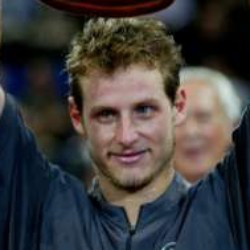

In [16]:
def recomender(vectors,names,path):
    mod = list(vectors)
    s_N = names
    s = pd.Series(s_N)
    df=pd.DataFrame(s)
    df['Vector']=mod
    df.columns=(['name','X'])
    test_person=load_dataset(path)
    test_person_pred=encodetor.predict(test_person)
    X_missing=test_person_pred
    df["diffs"] = df["X"].apply(lambda X: np.linalg.norm(X-X_missing))
    results = df.groupby("name").agg({'diffs':'min'}).sort_values(by='diffs')
    s = '/'
    #filename = re.findall("[\w\/\.\_\d]+",filename)
    filename = './data/'+s.join(results.index[0])
    image = Image.open('{}'.format(filename))
    return image
res = recomender(vectors,names,'./data/fotop/Alex/alex1.jpg')
res